In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD

In [4]:
batch_size = 32
dir_train = "./afhq/train"
dir_val = "./afhq/val"

train_images = keras.utils.image_dataset_from_directory(dir_train, seed=123, batch_size=batch_size, shuffle=True)
val_images = keras.utils.image_dataset_from_directory(dir_val, seed=123, batch_size=batch_size)

Found 14630 files belonging to 3 classes.
Found 1500 files belonging to 3 classes.


In [5]:
len(train_images.class_names)

3

In [6]:
type(train_images)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [7]:
print(tf.__version__)

2.8.0


In [8]:
class_names = train_images.class_names
print(class_names)

['cat', 'dog', 'wild']


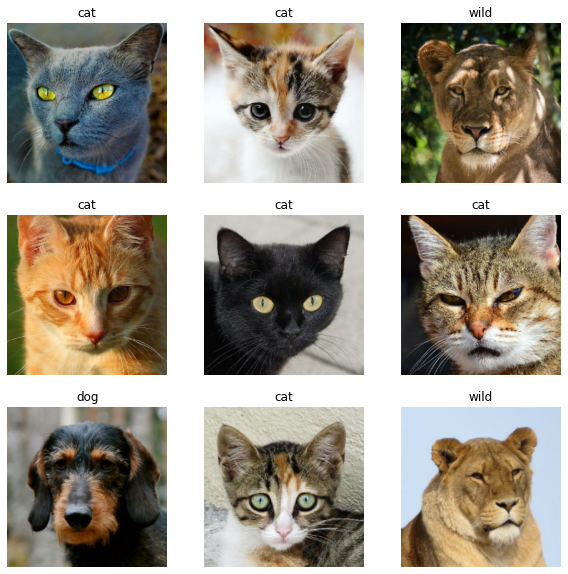

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_images.take(1):#take(1) used to take only one image at a time
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [30]:
for image_batch, labels_batch in train_images:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


In [31]:
AUTOTUNE = tf.data.AUTOTUNE

train_images = train_images.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_images = val_images.cache().prefetch(buffer_size=AUTOTUNE)

In [32]:
normalization_layer = layers.Rescaling(1./255)

In [12]:
model=keras.models.Sequential([
    keras.layers.Rescaling(1./255),
    keras.layers.RandomCrop(224,224),
    keras.layers.RandomFlip("horizontal"),
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(224,224,3)),
    keras.layers.Lambda(tf.nn.local_response_normalization),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.Lambda(tf.nn.local_response_normalization),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.Lambda(tf.nn.local_response_normalization),
    keras.layers.MaxPool2D(pool_size=(3,3)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(3,activation='softmax')  
])

In [13]:
SGD = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=False, name='SGD')
model.compile(optimizer=SGD, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

In [14]:
history = model.fit(train_images, epochs=3, batch_size=batch_size, validation_data=val_images)

Epoch 1/3
458/458 [==============================] - 1147s 2s/step - loss: 0.8623 - accuracy: 0.5731 - val_loss: 0.5737 - val_accuracy: 0.7633
Epoch 2/3
458/458 [==============================] - 949s 2s/step - loss: 0.3895 - accuracy: 0.8444 - val_loss: 0.2588 - val_accuracy: 0.8933
Epoch 3/3
458/458 [==============================] - 963s 2s/step - loss: 0.2487 - accuracy: 0.9062 - val_loss: 0.2538 - val_accuracy: 0.8913


In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 random_crop (RandomCrop)    (None, 224, 224, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 54, 54, 96)        34944     
                                                                 
 lambda (Lambda)             (None, 54, 54, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 26, 26, 96)       0         
 )                                                               
                                                        

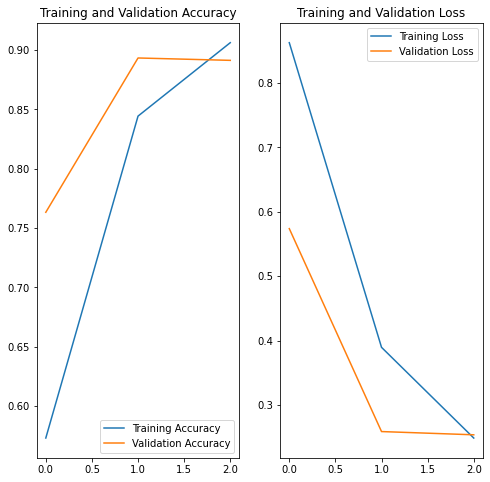

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(3)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [18]:
model.save('./savedModel',save_format='tf')

INFO:tensorflow:Assets written to: ./savedModel\assets


In [23]:
#Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\new\AppData\Local\Temp\tmp2hv57q5x\assets


INFO:tensorflow:Assets written to: C:\Users\new\AppData\Local\Temp\tmp2hv57q5x\assets


In [24]:
#Saving the model
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [33]:
new_model=tf.keras.models.load_model('./Saved_Model')

In [34]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 random_crop (RandomCrop)    (None, 224, 224, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 54, 54, 96)        34944     
                                                                 
 lambda (Lambda)             (None, 54, 54, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 26, 26, 96)       0         
 )                                                               
                                                        

In [19]:
new_history = new_model.fit(train_images, epochs=3, batch_size=batch_size, validation_data=val_images)

Epoch 1/3
458/458 [==============================] - 1047s 2s/step - loss: 0.1526 - accuracy: 0.9442 - val_loss: 0.1487 - val_accuracy: 0.9460
Epoch 2/3
458/458 [==============================] - 1038s 2s/step - loss: 0.1157 - accuracy: 0.9563 - val_loss: 0.1006 - val_accuracy: 0.9620
Epoch 3/3
458/458 [==============================] - 946s 2s/step - loss: 0.0850 - accuracy: 0.9697 - val_loss: 0.1122 - val_accuracy: 0.9567


In [22]:
model=new_model
model.save('./Saved_Model',save_format='tf')

INFO:tensorflow:Assets written to: ./Saved_Model\assets


Dog


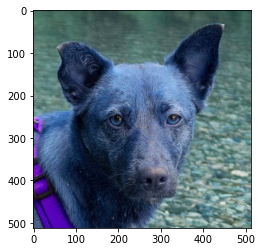

In [52]:
import cv2
img = cv2.imread('./afhq/val/dog/flickr_dog_000043.jpg')
plt.imshow(img)
image_resize=cv2.resize(img,(256,256))
image_resize = np.expand_dims(image_resize, axis=0)
y=new_model.predict(image_resize)
y=y.T
if y[0]>y[1] and y[0]>y[2]:
    print("Cat")
elif y[1]>y[0] and y[1]>y[2]:
    print("Dog")
else:
    print("Wild")

In [3]:
# import the opencv library
import cv2


# define a video capture object
vid = cv2.VideoCapture(0)

# while(True):
	
# 	# Capture the video frame
# 	# by frame
# 	ret, frame = vid.read()

# 	# Display the resulting frame
# 	cv2.imshow('frame', frame)
	
# 	# the 'q' button is set as the
# 	# quitting button you may use any
# 	# desired button of your choice
# 	if cv2.waitKey(1) & 0xFF == ord('q')
# 		break

# After the loop release the cap object
vid.release()
# Destroy all the window
cv2.destroyAllWindows()

In [6]:
# program to capture single image from webcam in python

# importing OpenCV library
import cv2

# initialize the camera
# If you have multiple camera connected with
# current device, assign a value in cam_port
# variable according to that
cam_port = 0
cam = cv2.VideoCapture(cam_port)

# reading the input using the camera
result, image = cam.read()

# If image will detected without any error,
# show result
if result:

	# showing result, it take frame name and image
	# output
	cv2.imshow("test_animal", image)

	# saving image in local storage
	cv2.imwrite("test_animal.jpg", image)

	# If keyboard interrupt occurs, destroy image
	# window
	cv2.waitKey(0)
	cv2.destroyWindow("test_animal")

# If captured image is corrupted, moving to else part
else:
	print("No image detected. Please! try again")


error: OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window_w32.cpp:1261: error: (-27:Null pointer) NULL window: 'test_animal' in function 'cvDestroyWindow'


In [5]:
new_model=tf.keras.models.load_model('./Saved_Model')
img = cv2.imread('./test_animal.jpg')
plt.imshow(img)
image_resize=cv2.resize(img,(256,256))
image_resize = np.expand_dims(image_resize, axis=0)
y=new_model.predict(image_resize)
y=y.T
if y[2]>y[0] and y[2]>y[1]:
    print('Wild')
else:
    print('Not Wild')

NameError: name 'tf' is not defined